## England Premier League

In [4]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from sklearn.preprocessing import LabelEncoder

In [5]:
#read_files = glob.glob("./data/*.csv")
#print(read_files)
df_list = []
for file in glob.glob('./data/*.csv'):
    season = int(file[19:23])
#    print(season)
    games = (pd.read_csv(file)).assign(Season=season)
    df_list.append(games)

games = pd.concat(df_list, sort=False)


In [6]:
games.head(5)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,Unnamed: 27,GBAHH,GBAHA,GBAH,LBAHH,LBAHA,LBAH,B365AHH,B365AHA,B365AH
0,E0,16/08/14,Arsenal,Crystal Palace,2.0,1.0,H,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,16/08/14,Leicester,Everton,2.0,2.0,D,1.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,16/08/14,Man United,Swansea,1.0,2.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,16/08/14,QPR,Hull,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,16/08/14,Stoke,Aston Villa,0.0,1.0,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

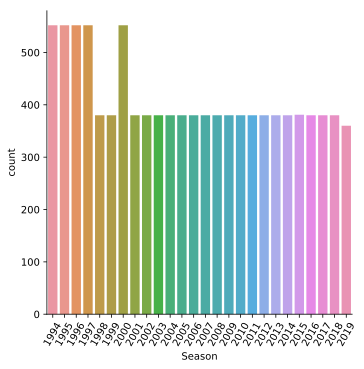

In [7]:
sns.catplot(x="Season", kind="count", data=games);
plt.xticks(rotation=60)

## Количество игр выигранных дома, на выезде и ничья

Из графика видно, что количество выигранных домашних игр больше, чем на выезде.

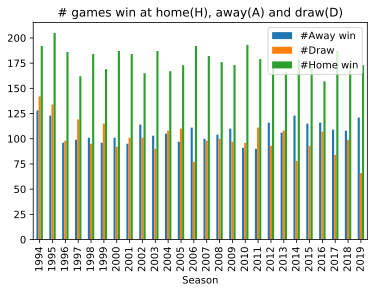

In [8]:
by_season_ftr = games.groupby(["Season", "FTR"])
count_by_season_ftr = by_season_ftr['FTHG'].aggregate('count').unstack()
ax = count_by_season_ftr.plot(kind = 'bar', title = '# games win at home(H), away(A) and draw(D)')
ax.legend(['#Away win', '#Draw', '#Home win'])
plt.show()
#title = ‘ by Regiment, Bucket’
#by_season_ftr = dict(list(games.groupby(["Season", "FTR"])))

## Качество предсказания исхода матча (букмейкер Interwetten) 

Рассмотрен букмейкер Interwetten, так как у него больше истории.

Исходные данные:
FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)

Коэффициенты матчей:
IWH = Interwetten home win odds
IWD = Interwetten draw odds
IWA = Interwetten away win odds

Оценка качества предсказания букмейкера:
min('IWH', 'IWD', 'IWA')  - наиболее вероятное событие. Если это событие произошло, то Quality_pred = true, если не произошло, то Quality_pred = false.

То есть в итоге будет добавлен столбец с качеством предсказания исхода матча букмейкером. Просуммировав количество удачных и неудачных предсказаний, мы поймем насколько точен букмейкер.



/home/ilya/anaconda3/envs/otus-ds/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


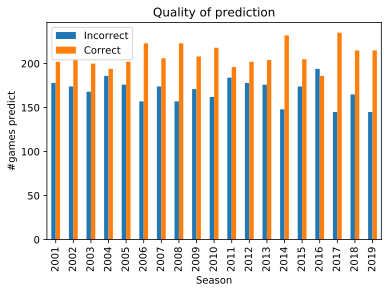

In [9]:
games_pure_bet = games.dropna(subset=['FTR', 'IWH', 'IWD', 'IWA'])


def bookmaker_predict_IW(odd_h, odd_d, odd_a, ftr):
    min_odd = min(odd_h, odd_d, odd_a)
    if (ftr == 'H'):
        return (min_odd == odd_h)
    elif (ftr == 'D'):
        return (min_odd == odd_d)
    elif (ftr == 'A'):
        return (min_odd == odd_a)

games_pure_bet['Quality_pred'] = games_pure_bet.apply(
    lambda row: bookmaker_predict_IW(row['IWH'], row['IWD'], row['IWA'], row['FTR']), axis=1)


by_season_quality_pred = games_pure_bet.groupby(["Season", "Quality_pred"])
count_by_season_quality_pred = by_season_quality_pred['FTHG'].aggregate('count').unstack()
ax = count_by_season_quality_pred.plot(kind = 'bar', title = 'Quality of prediction' )
ax.set_ylabel("#games predict")
ax.legend(["Incorrect", "Correct"]);
plt.show()


## Проверка стратегии ставок

In [10]:
bet = 100

def profit_IW(odd_h, odd_d, odd_a, quality_pred):
    min_odd = min(odd_h, odd_d, odd_a)
    if (quality_pred==True):
        return min_odd*bet
    else:
        return (-1) * bet   
    
games_pure_bet['Profit'] = games_pure_bet.apply(
    lambda row: profit_IW(row['IWH'], row['IWD'], row['IWA'], row['Quality_pred']), axis=1)



/home/ilya/anaconda3/envs/otus-ds/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [11]:
by_season = games_pure_bet.groupby(["Season"])
profit_by_season = by_season['Profit'].aggregate('sum')

In [19]:
profit_by_season

Season
2001    18885.0
2002    19230.0
2003    19790.0
2004    16934.0
2005    19345.0
2006    24752.0
2007    19763.0
2008    23611.0
2009    20089.0
2010    21613.0
2011    17417.0
2012    17615.0
2013    18340.0
2014    26175.0
2015    19505.0
2016    15547.0
2017    27146.0
2018    21576.0
2019    22493.0
Name: Profit, dtype: float64

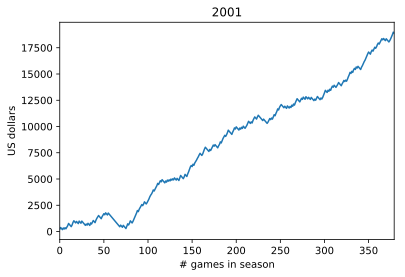

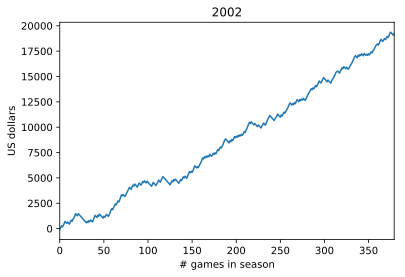

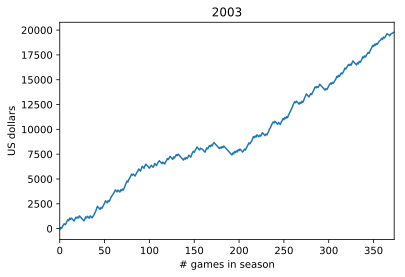

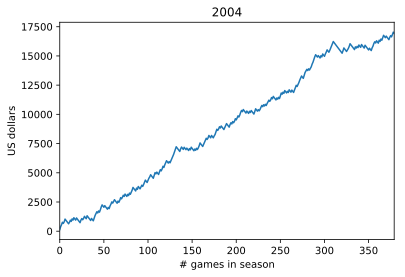

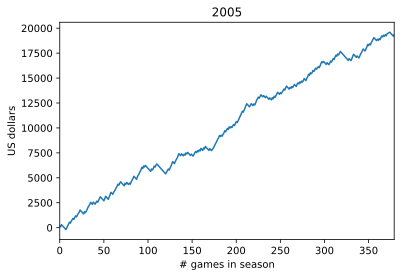

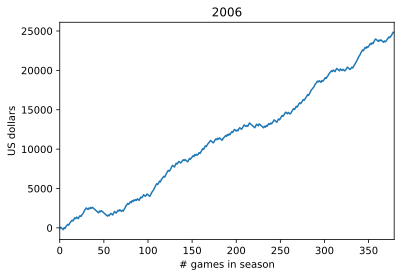

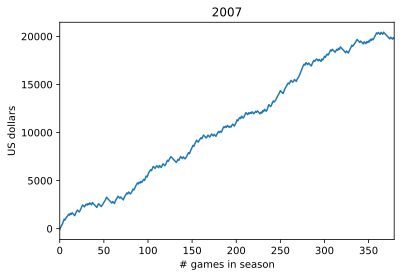

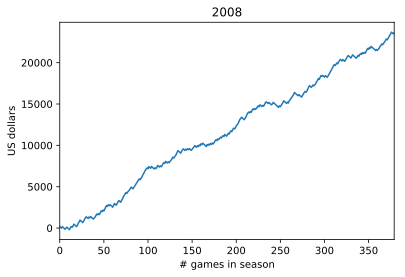

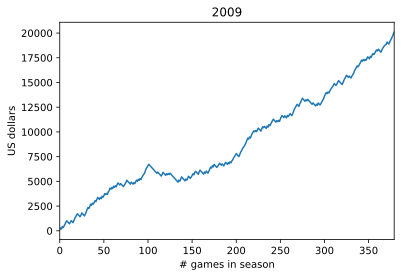

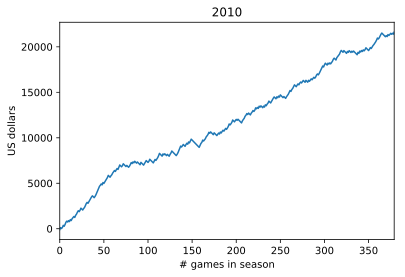

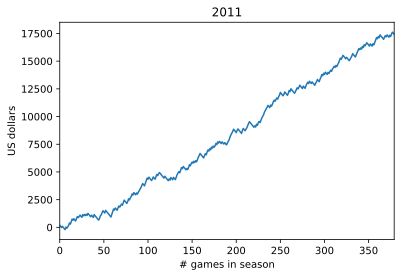

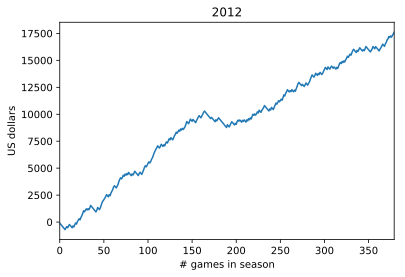

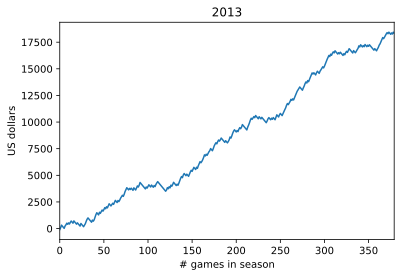

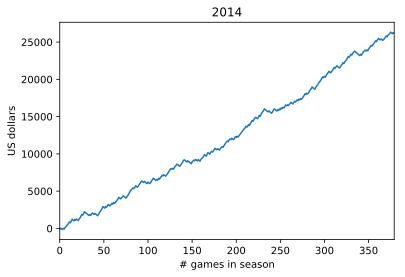

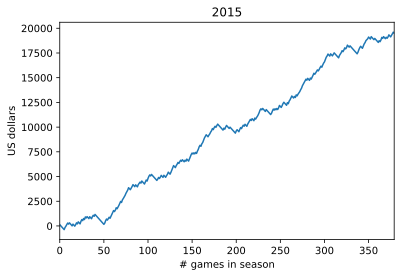

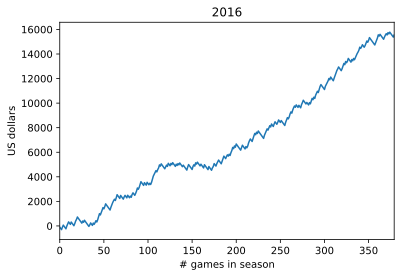

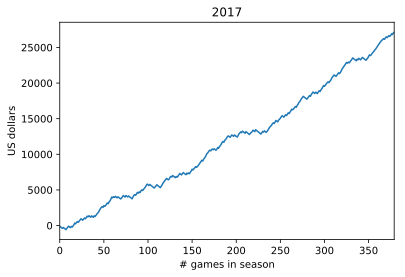

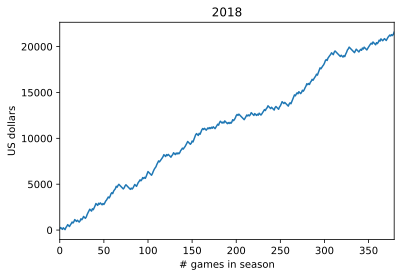

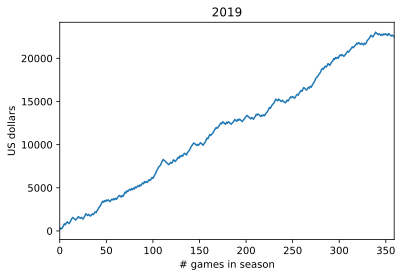

In [12]:
for season in range(2001,2020,1):
    plt.figure(season)
    ax = games_pure_bet[games_pure_bet["Season"] == season]['Profit'].cumsum().plot(title = season)
    ax.set_ylabel("US dollars")
    ax.set_xlabel("# games in season")